<div style="text-align: right"> &uarr;   Ensure Kernel is set to  &uarr;  </div><br><div style="text-align: right"> conda_amazonei_tensorflow2_p36  </div>

# Tensorflow Estimator Bring your own Script

In this notebook we will go through and run a tensorflow model to classify the junctions as priority, signal and roundabout as seen in data prep.

The outline of this notebook is 

1. To prepare a training script (provided).

2. Use the AWS provided Tensorflow container and provide our script to it.

3. Run training.

4. Deploy model to end point.

5. Test using an image in couple of possible ways 

Upgrade Sagemaker so we can access the latest containers

In [ ]:
!pip install -U 'sagemaker>=2.48'

Let us also upgrade out version of Tensorflow to v2.4.1

In [ ]:
!pip install tensorflow==2.4.1

Lets make sure that our environment is using Tensorflow 2.4.1 otherwise we will need to restart the notebook kernel

In [ ]:
import tensorflow as tf

print(f"Tensorflow version {tf.__version__}")

if tf.__version__ != "2.4.1":
    print("This notebook kernel needs to be restarted!!!!")
    exit()

Lets start by importing some libraries that we will be using later

In [ ]:
import os
import sagemaker
import numpy as np
from sagemaker.tensorflow import TensorFlow
import warnings
warnings.filterwarnings('ignore')


ON_SAGEMAKER_NOTEBOOK = True

sagemaker_session = sagemaker.Session()
if ON_SAGEMAKER_NOTEBOOK:
    role = sagemaker.get_execution_role()
else:
    role = "[YOUR ROLE]"


A quick sanity check to make sure we are using the latest version of SageMaker

In [ ]:
sagemaker.__version__

#### Input params for model training 

In the cell below, replace **"your-unique-bucket-name"** with the name of bucket you created in the data-prep notebook

In [ ]:
bucket = "amagroup-workshop-2022"

train_instance_type='ml.p3.2xlarge'      # The type of EC2 instance which will be used for training. 
deploy_instance_type='ml.m5.4xlarge'     # The type of EC2 instance which will be used for deployment

training_data_uri="s3://{}".format(bucket)

### Tensorflow Estimator

Starting with TensorFlow version 1.11, you can use Amazon **SageMaker prebuilt TensorFlow containers**: Simply provide (1) Python training script, (2) specify hyperparameters, and (3) indicate your training hardware configuration. SageMaker does the rest, including spinning up a training cluster and **tearing down the cluster when training ends**. 

These containers can be extended by starting with the image provided by AWS and the add additional installs in dockerfile or you can use requirements.txt in source_dir to install additional libraries.

We setup the Tensorflow estimator job a job name, an entry point (which is our script **tfModelCode.py**), role, Tensorflow framework version, python version, instance count and type. <br>
Then we call the estimators fit method with the URI of the training dataset to kick off the training job.<br>

**Distributed Training**

Before using distributed training in a cluster, we should first scale up on a single machine with more GPUs. Communication between multiple GPUs on a single machine is faster than communicating across a network between multiple machines. 

There are two options for distributed training.

*Option 1: TensorFlow’s native parameter server* <br>

Here, each instance in the cluster runs one parameter server process and one worker process. Each parameter server communicates with all workers (“all-to-all”). The implementation of parameter servers is asynchronous: each worker computes gradients and submits gradient updates to the parameter servers independently, without waiting for the other workers’ updates. Workers that fall behind might submit stale gradients, which can negatively affect training convergence. Generally, this can be managed by reducing the learning rate. On the plus side, because there is no waiting for other workers, asynchronous updates can result in faster training.

distributions parameter will have to be defined in the Tensorflow Estimator.<br> 
`distributions = {'parameter_server': {'enabled': True}}`

*Option 2: Horovod* 

Horovod is an open source framework for distributed deep learning. It is available for use with TensorFlow and several other deep learning frameworks. In Horovod updates are synchronous. After all processes have completed their calculations for the current batch, gradients calculated by each process circulate around the ring until every process has a complete set of gradients for the batch from all processes. At that time, each process updates its local model weights, so every process has the same model weights before starting work on the next batch.

`distributions = {"mpi": {"enabled": True, "custom_mpi_options": "-verbose --NCCL_DEBUG=INFO"}}`

if you use multi-GPU instance such as p3.8xlarge (4 GPU), you need to define the distributions as below.

`distributions = {"mpi": {"enabled": True, "processes_per_host": 4}}`


For more details on horovod implementation, please refer to:
https://aws.amazon.com/blogs/machine-learning/launching-tensorflow-distributed-training-easily-with-horovod-or-parameter-servers-in-amazon-sagemaker/


**Note**: 

- In this example, the training took 25 min with 23 min training time one instance of 'ml.m5.12xlarge' (CPU)
- It took the similar time with 2 instances of 'ml.m5.12xlarge' with distributed training enabled since data set is small (CPU)
- It took total 11.5 min with 9 min training time with one instance of 'ml.p3.2xlarge' (GPU)

In [ ]:
hyperparameters = { "epochs": 1, "learning_rate": 0.002}

In [ ]:
%%time
estimator_tf = TensorFlow(
  base_job_name='tensorflow-traffic-class',
  entry_point="tfModelCode.py",             # Your entry script
  role=role,
  framework_version="2.4.1",               # TensorFlow's version
  py_version="py37",
  instance_count=1,  # "The number of instances to use"
  distribution={ "parameter_server": { "enabled": False } },
  hyperparameters = hyperparameters,
  instance_type=train_instance_type,
)

print("Training ...")
estimator_tf.fit(training_data_uri)

## **NOTE:** <br>
If at this point your kernel disconnects from the server (you can tell because the kernel in the top right hand corner will say **No Kernel**, you can reattach to the training job (so you dont to start the training job again.<br>Follow the steps below
1. Scoll your notebook to the top and set the kernel to the recommended kernel specified in the top right hand corner of the notebook
2. Go to your SageMaker console, Go to Training Jobs and copy the name of the training job you were disconnected from
3. Scoll to the bottom of this notebook, paste your training job name to replace the **your-training-job-name** in the cell
4. Run the edited cell
5. Return to this cell and continue executing the rest of this notebook

### Deploying a model
Once trained, deploying a model is a simple call. <br>
We specify two prarameters<br>
    **instance_type** - the type of the instance will be used to do inference<br>
    **initial_instance_count** - the initial number of instances that will be provisioned to do inference

In [ ]:
estimator_deployed=estimator_tf.deploy(instance_type='ml.m5.2xlarge', initial_instance_count=1)

Now that the estimator has been deployed to an endpoint, lets find out the endpoint name

In [ ]:
print(estimator_deployed.endpoint_name)

So to do predictions against this endpoint, we are going to use **Predictor**. We provide it the endpoint name, the SageMaker session and the serializer (in our case a JSONSerializer)
Serializers implement methods for serializing data for an inference endpoint<br>

In [ ]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer

endpoint_name = estimator_deployed.endpoint_name   # you can also paste your endpoint name here from the cell above

predictor=Predictor(endpoint_name=endpoint_name,
                    sagemaker_session=sagemaker_session, 
                    serializer=JSONSerializer())

Here we install some convenience libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import json

Now we will take one of our test images and apply some preprocessing to it

In [ ]:
file='../data/test/Roundabout/R2.png'
img = tf.keras.preprocessing.image.load_img(file, target_size=[250, 250])
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img)
x = tf.keras.applications.efficientnet.preprocess_input(
    x[tf.newaxis,...])


Now we send that processed data to our endpoint.

In [ ]:
predictor.predict(x)

As you can see the prediction has sent back a confidence score for each class. The second value in the list corresponds to the class label "Roundabout" which has the highest confidence score

### Using boto3 sagemaker_runtime client

So what if we want to make predictions against this endpoint outside of this notebook?<br>
We then leverage the boto3 library. <br>
**NOTE** Replace **'your-endpoint-name'** with your endpoint name

In [ ]:
import boto3
client=boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='application/json',
            Body=json.dumps({'instances':x.tolist()}))

We can now view the JSON response. Again the second value in the list corresponds to the class label "Roundabout" which has the highest confidence score

In [ ]:
json.loads(response['Body'].read().decode("utf-8"))

### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [ ]:
predictor.delete_endpoint()

## Batch Inference

We will start by creating a S3 URI to the model artifacts package generated from the training step

In [ ]:
model_data = estimator_tf.model_data

First let us make sure we are in the correct starting folder

In [ ]:
%cd ~/SageMaker/sageMakerWorkshop/tensorflow/

Now we copy and unpack the model artifacts file

In [ ]:
!aws s3 cp {model_data} ./export/

In [ ]:
!tar -xvzf ./export/model.tar.gz -C ./export/

In [ ]:
%cd export

We now move the unpacked model artifacts folder to the 1 folder

In [ ]:
! mv tf000000001/1 .

In [ ]:
! rm -r code/.ipynb_checkpoints/

We now package up the code and 1 folder to create a new model.tar.gz file

In [ ]:
! tar -czvf model.tar.gz code 1

We copy the new model.tar.gz to your S3 bucket and setup our Tensorflow Serving Container https://github.com/aws/sagemaker-tensorflow-serving-container

In [ ]:
import os
import sagemaker
from sagemaker.tensorflow.model import TensorFlowModel
sm_role=sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
# See the following document for more on SageMaker Roles:
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html
role = sm_role

# Will be using the bucket variable defined at beginning of this notebook

prefix = 'tf_model'
s3_path = 's3://{}/{}'.format(bucket, prefix)

model_data = sagemaker_session.upload_data('model.tar.gz',
                                           bucket,
                                           os.path.join(prefix, 'model'))
                                           
tensorflow_serving_model = TensorFlowModel(model_data=model_data,
                                 role=role,
                                 framework_version='2.4.1',
                                 sagemaker_session=sagemaker_session)

We then specify the output folder and run the transformer method to start the batch processing

In [ ]:
%%time
output_path = f's3://{bucket}/{prefix}/output'
tensorflow_serving_transformer = tensorflow_serving_model.transformer(
                                     instance_count=2,
                                     instance_type='ml.m5.8xlarge',
                                     max_concurrent_transforms=64,
                                     max_payload=1,
                                     output_path=output_path)

input_path = f's3://{bucket}/test'
tensorflow_serving_transformer.transform(input_path, content_type='application/x-image')

The output of this batch job will be in the following S3 URI

In [ ]:
output_path

We can look at the output file from the batch job. Each file is a prediction that corresponds to the input image file name. You can have a look at the predictions inside the file. 

In [ ]:
! aws s3 ls {output_path} --recursive | grep -v ".ipy"

### (Optional) Hyper-parameter Optimization Job

In [ ]:
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.002, 0.004),
}

In [ ]:
objective_metric_name = "loss"
objective_type = "Minimize"
metric_definitions = [{ "Name": "loss", "Regex": "loss: ([0-9\\.]+)" }]

In [ ]:
# Keep per-job resources modest, so that parallel jobs don't hit any limits:
estimator_tf.instance_type = "ml.m5.24xlarge"
estimator_tf.instance_count = 1

In [ ]:
%%time
tuner = HyperparameterTuner(
    estimator_tf,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    base_tuning_job_name="tensorflow-traffic-hpo",
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

tuner.fit(training_data_uri)

### Check On Progress of HPO job

HPO jobs can take a long time to complete, and can run multiple training jobs in parallel - each on multiple instances.

If you want to check the status of HPO, you can go to the Training > Hyperparameter Tuning Jobs page of the [**SageMaker Console**](https://console.aws.amazon.com/sagemaker/home#/hyper-tuning-jobs) and select the job from the list.

You can see all the training jobs triggered for the HPO run, as well as overall metrics.

### Using the new model from HPO

We can take the best performing model from the HPO job and then follow the same process of deploying the model for batch inference

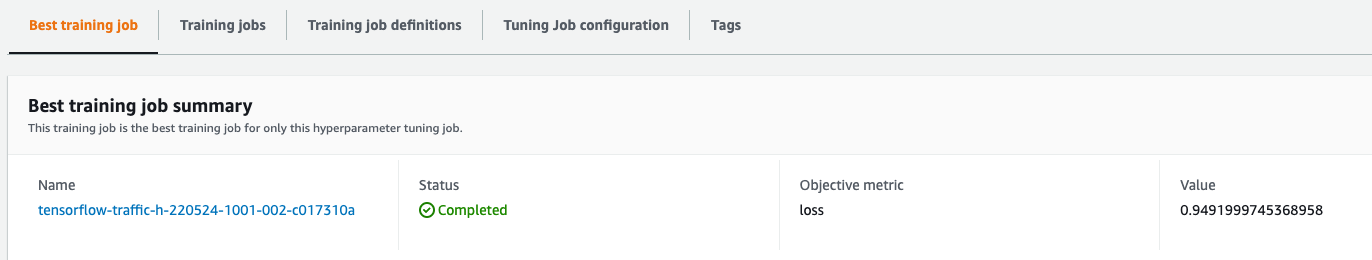

### (Optional) Attach to a training job that has been left to run 

If your kernel becomes disconnected and your training has already started, you can reattach to the training job.<br>
In the cell below, replace **your-unique-bucket-name** with the name of bucket you created in the data-prep notebook<br>
Then look up the training job name and replace the **your-training-job-name** and then run the cell below. <br>
Once the training job is finished, you can continue the cells after the training cell

In [ ]:
import tensorflow as tf
from sagemaker.tensorflow import TensorFlow
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = "your-unique-bucket-name"

training_job_name = 'your-training-job-name'

estimator_tf = TensorFlow.attach(training_job_name=training_job_name)

### Key Takeaways ###

Some benefits of using SageMaker for training and inference are:

- We can automatically provision specialist computing resources (e.g. high-performance, or GPU-accelerated instances) for **only** the duration of the training job: Getting good performance in training, without leaving resources sitting around under-utilized
- The history of training jobs (including parameters, metrics, outputs, etc.) is automatically tracked - unlike local notebook experiments where the user needs to keep notes on what worked and what didn't
- Our trained model can be deployed to a secure, production-ready web endpoint with just one SDK call: No container or web application packaging required, unless we want to customize the behaviour